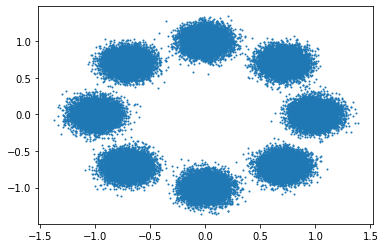

In [37]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import random
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 80000
dataset = CustomDataSet(n_group=8, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)
print(device)

cpu


In [46]:
def reparametrize(mu, sig):
    eps = torch.randn_like(sig).to(device)
    return mu + sig*eps


def log_density_gaussian(x, mu, sig): # Factorized Normal distribution
    return -torch.log(sig) - 0.5 * (np.log(2.0 * np.pi) + ((mu - x)/sig)**2)


def log_density_std_gaussian(x): # Factorized Normal distribution
    return - 0.5 * (np.log(2.0 * np.pi) + (x**2))


class VAE(torch.nn.Module):
    """TEST MODEL FOR DSPRITES DATASET"""

    def __init__(self):
        super(VAE, self).__init__()
        self.x_dim = 2
        self.z_dim = 2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.x_dim, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, self.z_dim*2)
        ).to(device)


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, self.x_dim * 2)
        ).to(device)
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def encode(self, x):
        qzx = self.encoder(x)
        qzx_mu = qzx[:, :self.z_dim]
        qzx_log_var = qzx[:, self.z_dim:]
        qzx_sig = torch.exp(0.5 * qzx_log_var)
        return qzx_mu, qzx_sig

    def decode(self, z):
        pxz = self.decoder(z)
        pxz_mu = pxz[:, :self.x_dim]
        pxz_log_var = pxz[:, self.x_dim:]
        pxz_sig = torch.exp(0.5 * pxz_log_var)
        return pxz_mu, pxz_sig 

    def forward(self, x):
        qzx_mu, qzx_sig = self.encode(x)
        pxz_mu, pxz_sig = self.decode(reparametrize(qzx_mu, qzx_sig))
        return qzx_mu, qzx_sig, pxz_mu, pxz_sig



def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [53]:
mb_size = 64
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)


vae = VAE()
vae_solver = optim.Adam(vae.parameters(), lr=1e-4)
X_DIM = 2
Z_DIM = 2

In [69]:
num_epochs = 1

alpha = 1.0 # index_z_MI
beta = 2.0 # TC
gamma = 1.0 # dim_kl


for epoch in range(num_epochs):
    RECON_AVG = 0.0
    TC_AVG = 0.0
    MI_AVG = 0.0
    DIMENSION_WISE_KL = 0.0
    for _, X in enumerate(loader):
        vae_solver.zero_grad()
        z_mu, z_sig, x_mu, x_sig = vae(X)
        
        z = reparametrize(z_mu, z_sig)

        log_qzx = torch.mean(log_density_gaussian(z, z_mu, z_sig)) * Z_DIM
        log_pz = torch.mean(log_density_std_gaussian(z)) * Z_DIM

        batch_log_qz = log_density_gaussian(z.view(mb_size ,1, Z_DIM), z_mu.view(1, mb_size, Z_DIM), z_sig.view(1, mb_size, Z_DIM))
        
        log_qz = torch.mean(torch.logsumexp(batch_log_qz.sum(2), dim=1, keepdim=False))
        log_prod_qz_d = torch.mean(torch.logsumexp(batch_log_qz, dim=1, keepdim=False).sum(1))

        mi = log_qzx - log_qz
        tc = log_qz - log_prod_qz_d
        dim_kl = log_prod_qz_d - log_pz

        recon_loss = -torch.mean(log_density_gaussian(X, x_mu, x_sig)) * X_DIM

        loss = recon_loss + alpha * mi + beta * tc + gamma * dim_kl
        loss.backward()
        vae_solver.step()
        RECON_AVG += recon_loss.item()
        TC_AVG += tc.item()
        MI_AVG += mi.item()
        DIMENSION_WISE_KL += dim_kl.item()

    print(RECON_AVG/len(loader), MI_AVG/len(loader), TC_AVG/len(loader), DIMENSION_WISE_KL/len(loader))

    

-1.1886606174707413 -1.7392133332252502 -4.158779553604126 8.464955728149414


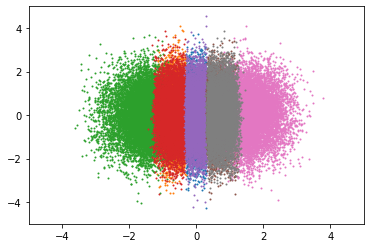

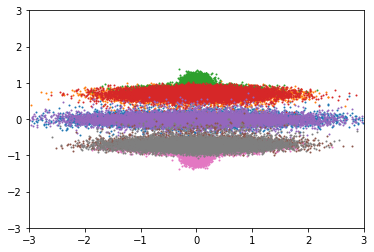

In [70]:
group = []
for k in range(dataset.n_group):
    group.append([])
np_data = dataset.data.numpy()
np_label = dataset.label.numpy()

for i in range(data_size):
    group[np_label[i]].append(np_data[i])

group = np.array(group)

for k in range(dataset.n_group):
    z_mu, z_sig, x_mu, x_sig = vae(torch.from_numpy(group[k]))
    z = reparametrize(z_mu, z_sig).detach().numpy()
    plt.scatter(z[:,0], z[:,1], s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

for k in range(dataset.n_group):
    z_mu, z_sig, x_mu, x_sig = vae(torch.from_numpy(group[k]))
    x = reparametrize(x_mu, x_sig).detach().numpy()
    plt.scatter(x[:,0], x[:,1], s=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()